In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import cv2
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount = True)

Mounted at /content/gdrive


In [ ]:
CURRENT = r"/content/gdrive/MyDrive/Eye"
# PATH = r"/content/gdrive/MyDrive/Neural Nets/Eye/train_images_resized_preprocessed"

In [ ]:
def load_data():
    os.chdir(CURRENT)
    file = open('df_train_train', 'rb')
    df_train_train = pickle.load(file)
    file.close()

    file = open('df_train_valid', 'rb')
    df_train_test = pickle.load(file)
    file.close()
    
    return df_train_train,df_train_test

In [ ]:
df_train_train, df_train_test = load_data()

In [ ]:
df_train_train

,id_code,diagnosis,file_path,file_name
2295,a125377fb985,2,./train_images/a125377fb985.png,a125377fb985.png
1672,7663aba8d762,2,./train_images/7663aba8d762.png,7663aba8d762.png
3299,e50b0174690d,0,./train_images/e50b0174690d.png,e50b0174690d.png
249,12b57dac703e,0,./train_images/12b57dac703e.png,12b57dac703e.png
3438,eedae6b28f96,0,./train_images/eedae6b28f96.png,eedae6b28f96.png
...,...,...,...,...
3358,e933923aab15,0,./train_images/e933923aab15.png,e933923aab15.png
2184,999ad827ed35,0,./train_images/999ad827ed35.png,999ad827ed35.png
173,0ceb222f6629,4,./train_images/0ceb222f6629.png,0ceb222f6629.png
2519,ae94ce412de9,0,./train_images/ae94ce412de9.png,ae94ce412de9.png


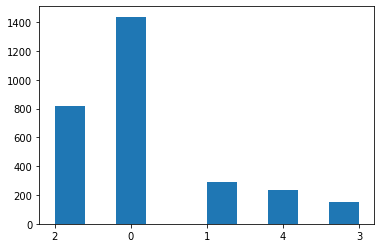

In [ ]:
plt.hist(df_train_train['diagnosis'])
plt.show()

In [ ]:
BATCH_SIZE = 50
HEIGHT = 224
WIDTH = 224

In [ ]:
train_datagen=ImageDataGenerator(rescale=1./255,validation_split = 0.0) #rotation_range=30,fill_mode='nearest',horizontal_flip=True
train_generator=train_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                      directory="./train_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='training')
valid_datagen=ImageDataGenerator(rescale=1./255,validation_split=0.99999)
valid_generator=valid_datagen.flow_from_dataframe(dataframe=df_train_test,
                                                      directory="./valid_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",    
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='validation')

Found 2929 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.


In [ ]:
model = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling=None,
    classes=1000,
)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
def CNN(model):
    x = model.outputs[-1]
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(5, activation="softmax")(x)

    model = models.Model(inputs=model.inputs, outputs=x)
    return model

In [ ]:
model = CNN(model)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
HIST = []
for c, (epoch, lr) in enumerate(zip([1, 5, 3], [1e-3, 1e-4, 1e-5])):  
  model.compile(optimizer=Adam(learning_rate=lr), loss=CategoricalCrossentropy(), metrics="accuracy")
  history = model.fit(train_generator, epochs=epoch, validation_data = valid_generator, verbose=1)
  HIST.append(history)
  np.save("./VGG16_history"+str(c)+".npy", np.array(HIST))
  model.save("./VGG16"+str(c)+".h5")

59/59 [==============================] - 1124s 19s/step - loss: 2.6917 - accuracy: 0.4490 - val_loss: 1.3096 - val_accuracy: 0.5000
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_10
.........vars
............0
............1
......conv2d_11
.........vars
............0
............1
......conv2d_12
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......conv2d_4
.........vars
............0
............1
......conv2d_5
.........vars
............0
............1
......conv2d_6
.........vars
............0
............1
......conv2d_7
.........vars
............0
............1
......conv2d_8
.........vars
............0
............1
......conv2d_9
.........vars
............0
............1
......dense
.........vars
............0
..........

In [ ]:
np.save("./VGG16_history.npy", np.array(HIST))
model.save("./VGG16.h5")

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_10
.........vars
............0
............1
......conv2d_11
.........vars
............0
............1
......conv2d_12
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......conv2d_4
.........vars
............0
............1
......conv2d_5
.........vars
............0
............1
......conv2d_6
.........vars
............0
............1
......conv2d_7
.........vars
............0
............1
......conv2d_8
.........vars
............0
............1
......conv2d_9
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......global_a